In [12]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/workspace/assignments/supervised_lieaning/k_nearest_neighbors")

import numpy as np
from dataset.cifar10_loader import CIFAR10Loader
from assignment import ModelExperimentManager
from assignment.experiment import TrainSizeExperiment, FeatureCompressExperiment, NumClassExperiment
SEED = 6
np.random.seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR10データのダウンロードと分割

In [2]:
data_loader = CIFAR10Loader(SEED)

CFAR10データセットはTrain用が50000枚、Test用が10000枚の画像データからなるセットです。ダウンロードできました。
Train用の2割をEvalation用にします。つまり (Train, Evaluation, Test) は (40000, 10000, 10000) の枚数からなります。


## 実験設定
1. 学習データ量の実験パターンは 学習データセット全体を 1 としたときの比率で指定する。設定は `TRAIN_RATIOS` で与える。
2. 特徴量の実験パターンは Notebook最下部の補足欄に示す主成分分析の結果を踏まえて定めた。設定は `FEATURE_DIMS` で与える。
3. クラス数の実験パターンの設定は `CLASS_GROUPS` で与える。

In [15]:
TRAIN_RATIOS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
CLASS_GROUPS = [
   ['cat', 'dog'],  # 2クラス
   ['cat', 'dog', 'horse'],   # 3クラス
   ['cat', 'dog', 'horse', 'frog'],   # 4クラス
   ['cat', 'dog', 'horse', 'frog', 'deer'], # 5クラス
   ['cat', 'dog', 'horse', 'frog', 'deer', "bird"], # 6クラス
   ['cat', 'dog', 'horse', 'frog', 'deer', "bird", 'airplane'], # 7クラス
   ['cat', 'dog', 'horse', 'frog', 'deer', "bird", 'airplane', 'automobile'], # 8クラス
   ['cat', 'dog', 'horse', 'frog', 'deer', "bird", 'airplane', 'automobile', 'ship'], # 9クラス
]
FEATURE_DIMS = [7, 10, 20, 25, 30, 50, 80, 125, 200]


これらの設定は、 後ほど`Experiment`系オブジェクトに与える。`XxxxExperiment`オブジェクトは、実験設定をデータに適用する役割を担う。
- 課題 1 のデータを扱う `TrainSizeExperiment` クラス
- 課題 2 のデータを扱う `NumClassExperiment` クラス
- 課題 3 のデータを扱う `FeatureCompressExperiment` クラス

各 `XxxxExperiment`オブジェクト は、実験を指揮する主体である `ModelExperimentManager` オブジェクトの `run_experiment()` 関数に与えられ、その内部で学習データ生成役として働く。

In [4]:
exp_mgr = ModelExperimentManager()

# 交差検証の設定
KNN_PARAMS = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

---
# 課題1：学習データ数を変化させたときの正解率の変化
どのクラスを用いるかで学習難易度が変わると感じたので、「犬と猫の分類」と「猫と自動車の分類」の2パターンを実施した。

#### 犬と猫の分類

Original Trainset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
Original Evalset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
Original Testset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
訓練データ 800個(10%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 1600個(20%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 2400個(30%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 3200個(40%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 4000個(50%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 4800個(60%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 5600個(70%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 6400個(80%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 7200個(90%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 7920個(99%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits


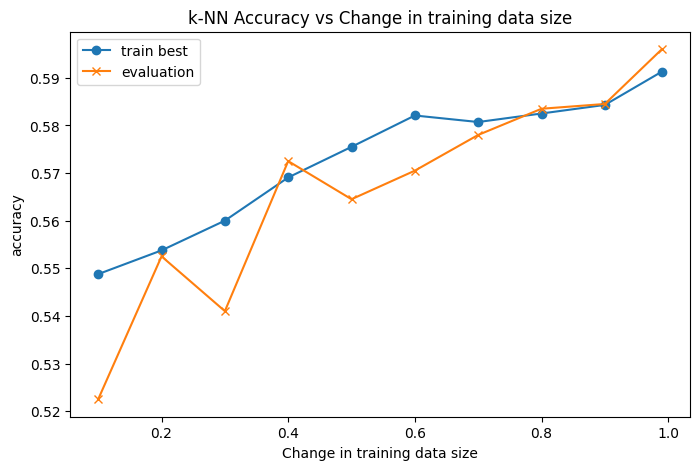

条件0.1 --> BestSetting({'n_neighbors': 11, 'weights': 'uniform'}) & Score(学習:0.5487736194418631, 検証:0.5225)
条件0.2 --> BestSetting({'n_neighbors': 7, 'weights': 'distance'}) & Score(学習:0.5537555073044248, 検証:0.5525)
条件0.3 --> BestSetting({'n_neighbors': 1, 'weights': 'uniform'}) & Score(学習:0.56, 検証:0.541)
条件0.4 --> BestSetting({'n_neighbors': 5, 'weights': 'distance'}) & Score(学習:0.5690708168706661, 検証:0.5725)
条件0.5 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.5754975100596739, 検証:0.5645)
条件0.6 --> BestSetting({'n_neighbors': 9, 'weights': 'uniform'}) & Score(学習:0.5820833333333333, 検証:0.5705)
条件0.7 --> BestSetting({'n_neighbors': 7, 'weights': 'uniform'}) & Score(学習:0.5807122177883944, 検証:0.578)
条件0.8 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.5825016151041641, 検証:0.5835)
条件0.9 --> BestSetting({'n_neighbors': 9, 'weights': 'distance'}) & Score(学習:0.5843055555555555, 検証:0.5845)
条件0.99 --> BestSetting({'n_neighbors': 7, 'weights': '

In [5]:
# データは犬と猫の2クラスに絞ったサブセットを使用
train_dset, eval_dset, _ = data_loader.get_datasubsets(['cat', 'dog'], verbose=True)

tr_exp1 = TrainSizeExperiment(train_dset, eval_dset, TRAIN_RATIOS, SEED) # 実験設定をデータに反映
tracker_tr1 = exp_mgr.run_experiment(tr_exp1, KNN_PARAMS) # 実験の実行
tracker_tr1.log_results()

#### 猫と自動車の分類

Original Trainset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
Original Evalset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
Original Testset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
訓練データ 800個(10%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 1600個(20%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 2400個(30%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 3200個(40%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 4000個(50%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 4800個(60%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 5600個(70%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 6400個(80%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 7200個(90%) で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
訓練データ 7920個(99%) で学習
Fitting 3 folds for each of 12 candidate

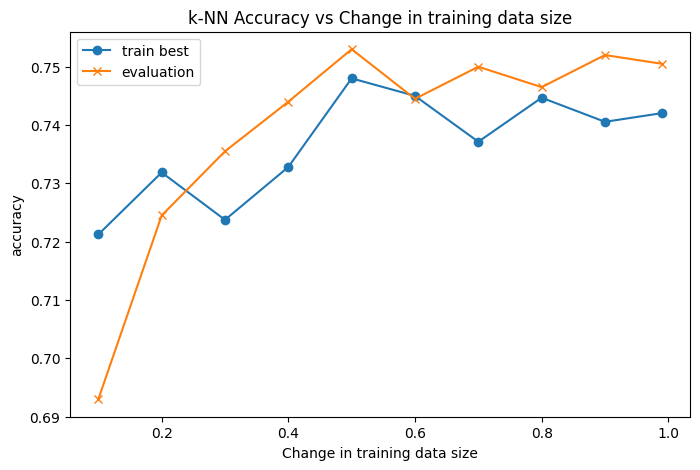

条件0.1 --> BestSetting({'n_neighbors': 3, 'weights': 'uniform'}) & Score(学習:0.7212413055109684, 検証:0.693)
条件0.2 --> BestSetting({'n_neighbors': 5, 'weights': 'uniform'}) & Score(学習:0.7318724483701189, 検証:0.7245)
条件0.3 --> BestSetting({'n_neighbors': 3, 'weights': 'uniform'}) & Score(学習:0.72375, 検証:0.7355)
条件0.4 --> BestSetting({'n_neighbors': 7, 'weights': 'distance'}) & Score(学習:0.7328103963758981, 検証:0.744)
条件0.5 --> BestSetting({'n_neighbors': 5, 'weights': 'distance'}) & Score(学習:0.7480039050242321, 検証:0.753)
条件0.6 --> BestSetting({'n_neighbors': 1, 'weights': 'uniform'}) & Score(学習:0.745, 検証:0.7445)
条件0.7 --> BestSetting({'n_neighbors': 3, 'weights': 'distance'}) & Score(学習:0.7371394596700597, 検証:0.75)
条件0.8 --> BestSetting({'n_neighbors': 1, 'weights': 'uniform'}) & Score(学習:0.7446853150233027, 検証:0.7465)
条件0.9 --> BestSetting({'n_neighbors': 1, 'weights': 'uniform'}) & Score(学習:0.7405555555555555, 検証:0.752)
条件0.99 --> BestSetting({'n_neighbors': 1, 'weights': 'uniform'}) & Score(

In [6]:
# データは猫と自動車の2クラスに絞ったサブセットを使用
train_dset, eval_dset, _ = data_loader.get_datasubsets(['cat', 'automobile'], verbose=True)

tr_exp2 = TrainSizeExperiment(train_dset, eval_dset, TRAIN_RATIOS, SEED) # 実験設定をデータに反映
tracker_tr2 = exp_mgr.run_experiment(tr_exp2, KNN_PARAMS) # 実験の実行
tracker_tr2.log_results()

## 考察
データ数を増加させると正解率が改善する傾向がある。

正解率は、①犬と猫の分類 が50%台と低めで、②猫と自動車の分類 は70%台と高めという結果であった。これは①の方が特徴量が類似しており難しそうだという直観と一致する。  
①については、学習データを増やすにつれて正解率が向上していることから、さらにデータを追加することでモデルの性能を向上させることができそうである。  
これに対して、②はデータ数を増やしても正解率が横這いになっており、これ以上データ数を増加させても正解率の改善は見込めないかもしれない。このタスクにおけるknn法の限界を感じる。

---
# 課題 2：クラス数を変化させたときの正解率の変化

クラス数 2 個で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
クラス数 3 個で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
クラス数 4 個で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
クラス数 5 個で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
クラス数 6 個で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
クラス数 7 個で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
クラス数 8 個で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
クラス数 9 個で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits


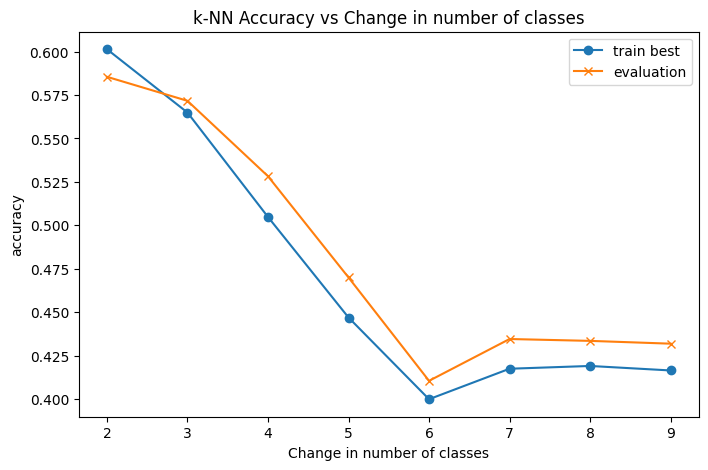

条件2 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.6013752219457189, 検証:0.5855)
条件3 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.5649166666666666, 検証:0.5716666666666667)
条件4 --> BestSetting({'n_neighbors': 9, 'weights': 'distance'}) & Score(学習:0.5048124023874476, 検証:0.52825)
条件5 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.4469501547424879, 検証:0.47)
条件6 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.39991666666666664, 検証:0.4105)
条件7 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.41746423065876276, 検証:0.43457142857142855)
条件8 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.4190625594140882, 検証:0.4335)
条件9 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.4164722222222222, 検証:0.4318888888888889)


In [7]:
nclass_exp1 = NumClassExperiment(data_loader, CLASS_GROUPS, SEED, dims=25) # 実験設定をデータに反映
tracker_cls1 = exp_mgr.run_experiment(nclass_exp1, KNN_PARAMS) # 実験の実行
tracker_cls1.log_results()

### 考察
分類クラス数が増えるほど正解率は低下する傾向が観察された。これはk-NNが距離ベースの分類アルゴリズムであることから、納得のいく結果だと考えられる。データ空間において、特徴量が類似したクラスは近いところに分布することになり、互いに重なりが生じるようになる。

今回の実験で、6クラス分類よりも7クラス分類の方が正解率が改善したのは、異なる特徴量を持つ対象物を加えたからだと考えられる。2~6クラス分類の間は対象を動物で揃えていたのに対して、6クラス分類までは既存のクラスの分布に近いところにあるデータ（全て動物）を追加していたのに対して、7クラス分類以降加えたデータ（乗り物）は特徴量の分布が異なっていたからではないかと考えられる。

---
# 課題 3：特徴量数を変化させたときの正解率の変化
#### 犬と猫の分類

Original Trainset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
Original Evalset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
Original Testset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
特徴量数 7 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 10 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 20 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 25 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 30 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 50 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 80 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 125 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 200 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits


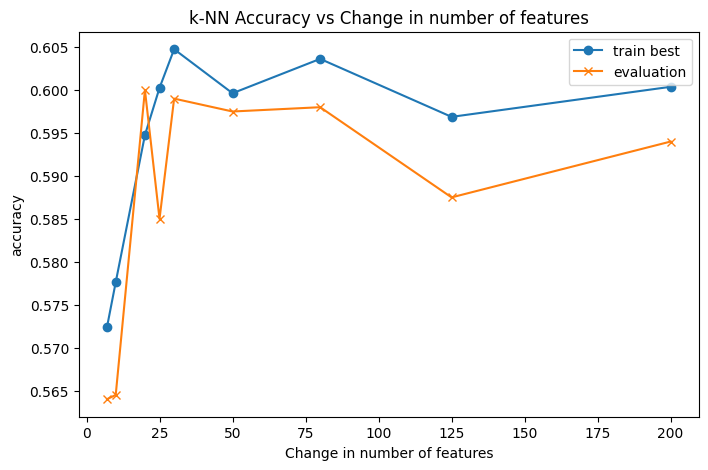

条件7 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.5723757523557867, 検証:0.564)
条件10 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.5776252368303925, 検証:0.5645)
条件20 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.5947510499672163, 検証:0.6)
条件25 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.6002503625531429, 検証:0.585)
条件30 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.6047512534301555, 検証:0.599)
条件50 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.5996250187406243, 検証:0.5975)
条件80 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.6036258783481022, 検証:0.598)
条件125 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.5968750811624917, 検証:0.5875)
条件200 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.6003750656449264, 検証:0.594)


In [16]:
# データは猫と犬の2クラスに絞ったサブセットを使用
train_dset, eval_dset, _ = data_loader.get_datasubsets(['cat', 'dog'], verbose=True)

fcomp_exp1 = FeatureCompressExperiment(train_dset, eval_dset, FEATURE_DIMS) # 実験設定をデータに反映
tracker_fcomp1 = exp_mgr.run_experiment(fcomp_exp1, KNN_PARAMS) # 実験の実行
tracker_fcomp1.log_results()

#### 猫と自動車の分類

Original Trainset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
Original Evalset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
Original Testset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
特徴量数 7 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 10 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 20 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 25 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 30 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 50 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 80 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 125 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 200 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits


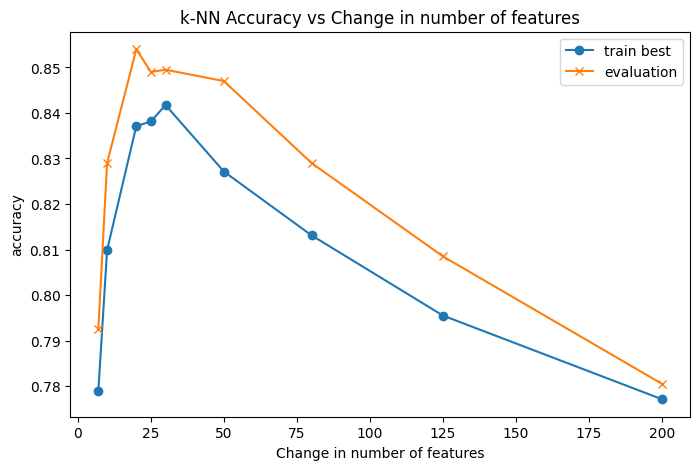

条件7 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.7788738054404866, 検証:0.7925)
条件10 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.809874525249235, 検証:0.829)
条件20 --> BestSetting({'n_neighbors': 7, 'weights': 'distance'}) & Score(学習:0.8371243542044117, 検証:0.854)
条件25 --> BestSetting({'n_neighbors': 5, 'weights': 'distance'}) & Score(学習:0.8381246042669273, 検証:0.849)
条件30 --> BestSetting({'n_neighbors': 9, 'weights': 'distance'}) & Score(学習:0.8417491980794223, 検証:0.8495)
条件50 --> BestSetting({'n_neighbors': 7, 'weights': 'distance'}) & Score(学習:0.827123306885964, 検証:0.847)
条件80 --> BestSetting({'n_neighbors': 3, 'weights': 'distance'}) & Score(学習:0.813123462717948, 検証:0.829)
条件125 --> BestSetting({'n_neighbors': 3, 'weights': 'distance'}) & Score(学習:0.7954979933584821, 検証:0.8085)
条件200 --> BestSetting({'n_neighbors': 3, 'weights': 'distance'}) & Score(学習:0.777123508473669, 検証:0.7805)


In [17]:
# データは猫と自動車の2クラスに絞ったサブセットを使用
train_dset, eval_dset, _ = data_loader.get_datasubsets(['cat', 'automobile'], verbose=True)

fcomp_exp2 = FeatureCompressExperiment(train_dset, eval_dset, FEATURE_DIMS) # 実験設定をデータに反映
tracker_fcomp2 = exp_mgr.run_experiment(fcomp_exp2, KNN_PARAMS) # 実験の実行
tracker_fcomp2.log_results()

#### クラス数を9に増やして再実験

Original Trainset-1.0 -> ラベル['cat', 'dog', 'horse', 'frog', 'deer', 'bird', 'airplane', 'automobile', 'ship']が付与された画像データを抽出します。
Original Evalset-1.0 -> ラベル['cat', 'dog', 'horse', 'frog', 'deer', 'bird', 'airplane', 'automobile', 'ship']が付与された画像データを抽出します。
Original Testset-1.0 -> ラベル['cat', 'dog', 'horse', 'frog', 'deer', 'bird', 'airplane', 'automobile', 'ship']が付与された画像データを抽出します。
特徴量数 7 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 10 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 20 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 25 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 30 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 50 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 80 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 125 次元で学習
Fitting 3 folds for each of 12 candidates, totalling 36 fits
特徴量数 200 次元で学習
Fit

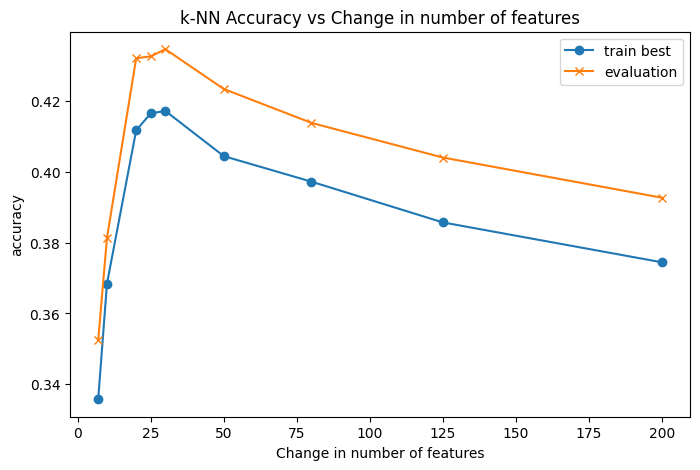

条件7 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.3358055555555555, 検証:0.35244444444444445)
条件10 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.36841666666666667, 検証:0.38133333333333336)
条件20 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.4116666666666666, 検証:0.432)
条件25 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.4164722222222222, 検証:0.4325555555555556)
条件30 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.4171388888888889, 検証:0.43455555555555553)
条件50 --> BestSetting({'n_neighbors': 11, 'weights': 'distance'}) & Score(学習:0.40438888888888885, 検証:0.42333333333333334)
条件80 --> BestSetting({'n_neighbors': 9, 'weights': 'distance'}) & Score(学習:0.39719444444444446, 検証:0.4137777777777778)
条件125 --> BestSetting({'n_neighbors': 9, 'weights': 'distance'}) & Score(学習:0.3856944444444444, 検証:0.404)
条件200 --> BestSetting({'n_neighbors': 5, 'weights': 'distance'}) & Sc

In [18]:
train_set, eval_set, _ = data_loader.get_datasubsets(
    ['cat', 'dog', 'horse', 'frog', 'deer', "bird", 'airplane', 'automobile', 'ship'],
    verbose=True)
fcomp_exp3 = FeatureCompressExperiment(train_set, eval_set, FEATURE_DIMS) # 実験設定をデータに反映
tracker_fcomp3 = exp_mgr.run_experiment(fcomp_exp3, KNN_PARAMS) # 実験の実行
tracker_fcomp3.log_results()

## 考察
「犬と猫」「猫と自動車」の2クラスデータに対して実験をしたところ、異なる傾向を示した。「猫と自動車」の方が第20-30主成分付近をピークに徐々に減少する結果であった。念のため9クラス分類でも試したが、正解率の推移の様子は同じ傾向であった。

一般的に次元数を増やすほど情報が増えることから、私は主成分数がデータの次元数に近づくほど正解率が向上していくものだと想像しており、非常に驚いた。PCAアルゴリズムの特徴は、第 i 主成分の i が若い番号ほど有用な情報を含むというものであった。今回の現象は、次元を増やしても分類に役立つ情報が増えず、むしろ誤判別を生むようなノイズが増幅したということだと考えられる。

# 補足
### 主成分の説明力の調査

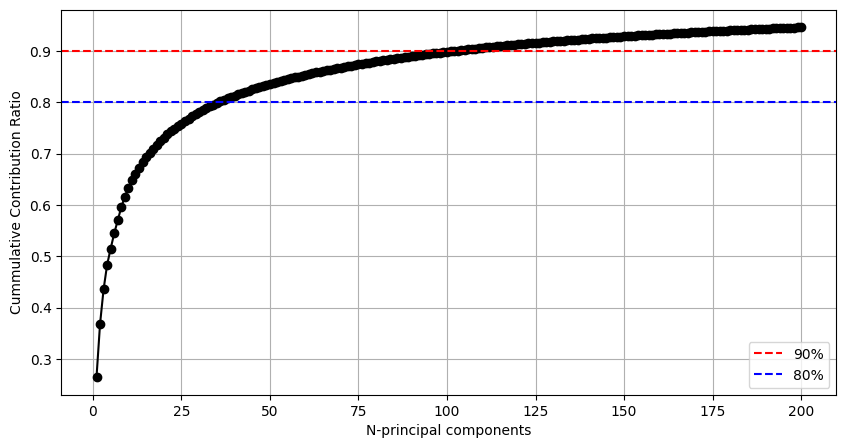

In [11]:
from assignment.pca_image_compressor import PCAImageCompressor

model = PCAImageCompressor(200)
x_reduced = model.fit_transform(train_dset)
model.plot_cummulative_contribution_ratio()